Ridge, Lasso y Elasticnet y problemas mal condicionados
===

* *60 min* | Ultima modificación: Junio 22, 2019

En este tutorial se aborda el problema de estimación de problemas mal condicionados en regresión, debido al sobreajuste y memorización de datos

## Problemas mal condicionados

### Preparación

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
import math

### Proceso generador de datos

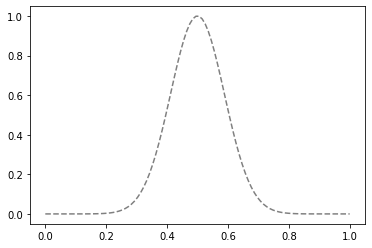

In [7]:
##
## Campana de Gauss
##
def f(x):
    x_scaled = [8*z-4 for z in x]
    y = [math.exp(-(e**2)) for e in x_scaled]
    return np.array(y)

##
## Note que x está definida en el intervalo [0, 1]
##
x_real = np.linspace(start=0.0, stop=1.0, num=100)

d_real = f(x_real)
plt.plot(x_real, d_real, '--', color='gray');

### Muestra de datos

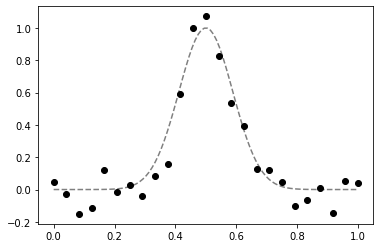

In [10]:
##
## Solo son observables 25 puntos
##
x_data = np.linspace(start=0.0, stop=1.0, num=25)

##
## La variable dependiente está contaminada con ruído
##
np.random.seed(123456)
d_data = f(x_data) + np.random.normal(0, 0.1, len(x_data))
plt.plot(x_real, d_real, '--', color='gray');
plt.plot(x_data, d_data, 'o', color='black');

### Modelo polinomial de regresión

Por facilidad, se usará un polinomio de grado $N$=6 para realizar la regresión:

$$y_p = g(x_p) = \phi_0 + \sum_{n=1}^N \phi_n x_p^n$$

donde el subíndice $p$ representa cada uno de los puntos de la muestra de datos.

### Función de pérdida

$$\text{SSE} = \sum_{p=1}^P (d_p - y_p)^2 = \sum_{p=1}^P [d_p - g(x_p)]^2$$ 

### Estimación de los coeficientes de la regresión

In [11]:
def model(N):
    w = np.polyfit(x_data, d_data, N)
    return np.poly1d(w)

### Ajuste para distintos grados del polinomio

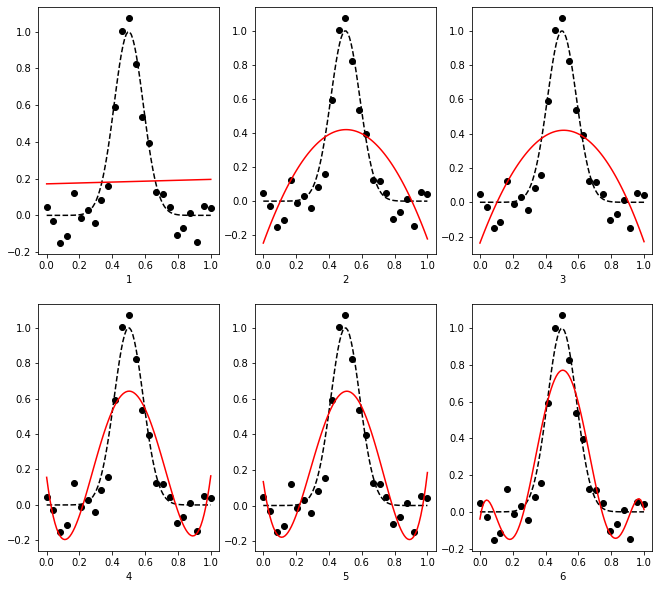

In [12]:
plt.figure(figsize=(11,10))

grados = [1, 2, 3, 4, 5, 6]

for i, n in enumerate(grados):
    m = model(n)
    y_data = m(x_data)
    y_real = m(x_real)

    plt.subplot(2, 3, i+1)
    plt.plot(x_data, d_data, 'o', color='black');
    plt.plot(x_real, d_real, '--', color='black');
    plt.plot(x_real, y_real, color='red')
    plt.xlabel(n);

### Variación en los coeficientes del modelo debido al aumento del grado del polinomio

In [13]:
def coeffs(N):
    return np.flip(np.polyfit(x_data, d_data, N))

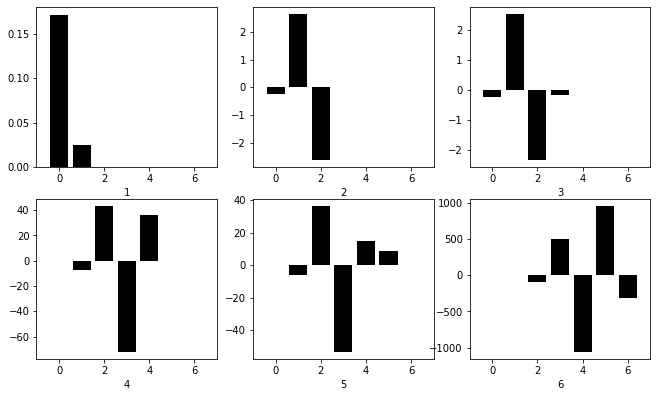

In [14]:
plt.figure(figsize=(11,10))

grados = [1, 2, 3, 4, 5, 6]

for i, n in enumerate(grados):
    m = coeffs(n)
    plt.subplot(3, 3, i+1)
    plt.bar(range(0, len(m)), m, color='black')
    plt.xlabel(n)
    plt.xlim(-1, 7);
    
##
## Note como cambian los valores del eje Y de una gráfica
## a la otra. Este es un problema mal condicionado
##

### Variación debido al conjunto de datos

In [17]:
df = pd.DataFrame({
    'y': d_data,
    'x': x_data
})
df['x2'] = df.x ** 2
df['x3'] = df.x ** 3
df['x4'] = df.x ** 4
df['x5'] = df.x ** 5
df['x6'] = df.x ** 6
df.head(10)

##
## Se genera un set de datos para N = 6
##

,y,x,x2,x3,x4,x5,x6
0,0.046911,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,-0.028285,0.041667,0.001736,0.000072,0.000003,1.255867e-07,5.232781e-09
2,-0.150891,0.083333,0.006944,0.000579,0.000048,4.018776e-06,3.348980e-07
3,-0.113440,0.125000,0.015625,0.001953,0.000244,3.051758e-05,3.814697e-06
4,0.122027,0.166667,0.027778,0.004630,0.000772,1.286008e-04,2.143347e-05
5,-0.013001,0.208333,0.043403,0.009042,0.001884,3.924586e-04,8.176220e-05
6,0.030237,0.250000,0.062500,0.015625,0.003906,9.765625e-04,2.441406e-04
7,-0.042247,0.291667,0.085069,0.024812,0.007237,2.110736e-03,6.156314e-04
8,0.082828,0.333333,0.111111,0.037037,0.012346,4.115226e-03,1.371742e-03
9,0.157423,0.375000,0.140625,0.052734,0.019775,7.415771e-03,2.780914e-03


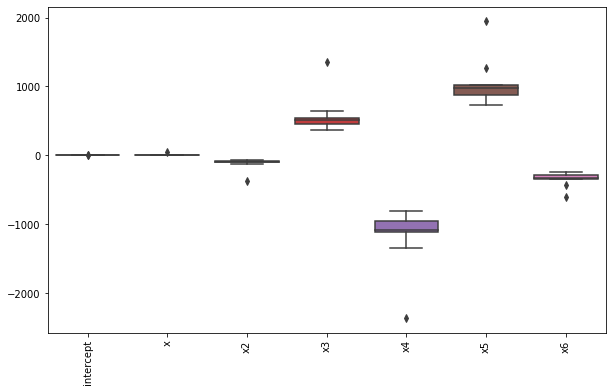

In [18]:
##
## Se aplica cross-validation para mostrar la variabilidad de los 
## coeficientes del polinomio debido al cambio del subconjunto de
## datos usados para el entrenamiento
##

from sklearn.model_selection import KFold
from sklearn import linear_model

r = pd.DataFrame()

kf = KFold(n_splits=10)                        
for train, test in kf.split(range(25)):
    
    regr = linear_model.LinearRegression()
    m = regr.fit(df.loc[train, ['x', 'x2', 'x3', 'x4', 'x5', 'x6']].values, df.y[train])
    
    s = pd.DataFrame({
        'intercept': m.intercept_,
        'x':  [m.coef_[0]],
        'x2': [m.coef_[1]],
        'x3': [m.coef_[2]],
        'x4': [m.coef_[3]],
        'x5': [m.coef_[4]],
        'x6': [m.coef_[5]]
    })
    
    r = pd.concat([r, s])
    
plt.figure(figsize=(10, 6))
sns.boxplot(data=r)
plt.xticks(rotation=90);    

## Ridge Regression

En la regresión ridge, se adiciona una penalización asociada al tamaño de los coeficientes de la regresión:

$$ \sum_{i=1}^N (y_i -  w_0 - \sum_{p=0}^P w_p x_{i,p})^2 + \alpha * \sum_{p=0}^P w_p^2 $$


donde $\alpha$ es el peso de la penalización.

### Efecto de alpha en los coeficientes

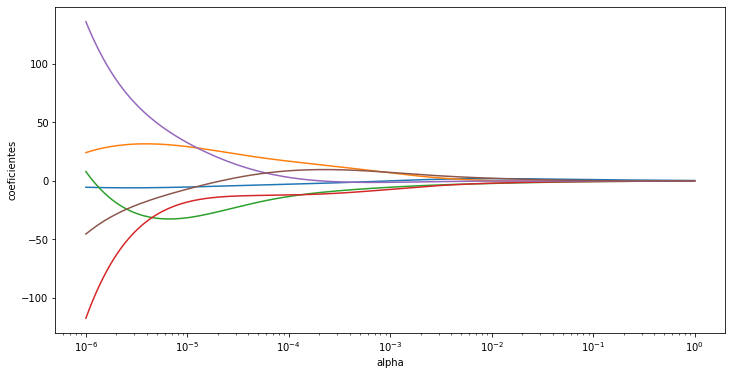

In [26]:
from sklearn.linear_model import Ridge

ridge = Ridge(
    alpha=1.0,           #
    fit_intercept=True,  #
    normalize=False,     #
    copy_X=True,         #
    max_iter=None,       #
    tol=0.001,           #
    solver='auto',       # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'}
    random_state=None)   #

coefs = []

alphas = np.logspace(-6, 0, 200)

y = df.y
X = df[['x', 'x2', 'x3', 'x4', 'x5', 'x6']]

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(12, 6))
plt.plot(alphas, coefs)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coeficientes')
plt.axis('tight');

### Estimación del valor óptimo usando cross-validation

In [41]:
from sklearn.linear_model import RidgeCV

ridgeCV = RidgeCV(
    alphas = 10 ** np.linspace(-10, -3, 200),
    cv = None,
    store_cv_values = True
)

ridgeCV.fit(X, y)

RidgeCV(alphas=array([1.00000000e-10, 1.08436597e-10, 1.17584955e-10, 1.27505124e-10,
       1.38262217e-10, 1.49926843e-10, 1.62575567e-10, 1.76291412e-10,
       1.91164408e-10, 2.07292178e-10, 2.24780583e-10, 2.43744415e-10,
       2.64308149e-10, 2.86606762e-10, 3.10786619e-10, 3.37006433e-10,
       3.65438307e-10, 3.96268864e-10, 4.29700470e-10, 4.65952567e-10,
       5.05263107e-10, 5.47890118e-1...
       2.14614120e-04, 2.32720248e-04, 2.52353917e-04, 2.73644000e-04,
       2.96730241e-04, 3.21764175e-04, 3.48910121e-04, 3.78346262e-04,
       4.10265811e-04, 4.44878283e-04, 4.82410870e-04, 5.23109931e-04,
       5.67242607e-04, 6.15098579e-04, 6.66991966e-04, 7.23263390e-04,
       7.84282206e-04, 8.50448934e-04, 9.22197882e-04, 1.00000000e-03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=True)

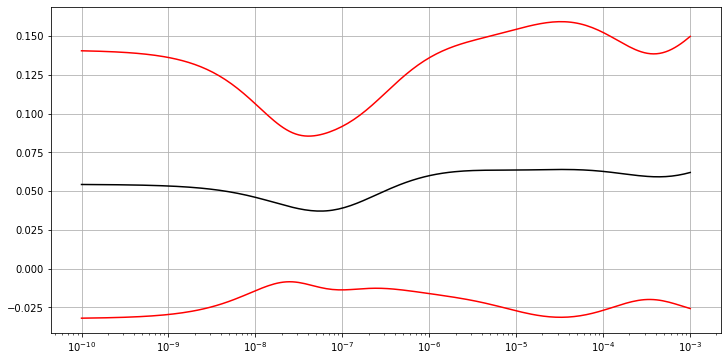

In [42]:
##
## Media del error de CV e intervalos de confianza
##

vmean = np.mean(ridgeCV.cv_values_, axis = 0)
vstd = np.std(ridgeCV.cv_values_, axis = 0)
vup = vmean + 1 * vstd
vlow = vmean - 1 * vstd

plt.figure(figsize=(12, 6))

plt.semilogx(
    ridgeCV.alphas, 
    vmean,
    color='black');

plt.semilogx(
    ridgeCV.alphas, 
    vup, 
    color = 'red');

plt.semilogx(
    ridgeCV.alphas, 
    vlow,
    color = 'red');

plt.grid()


### Variabilidad de los coeficientes

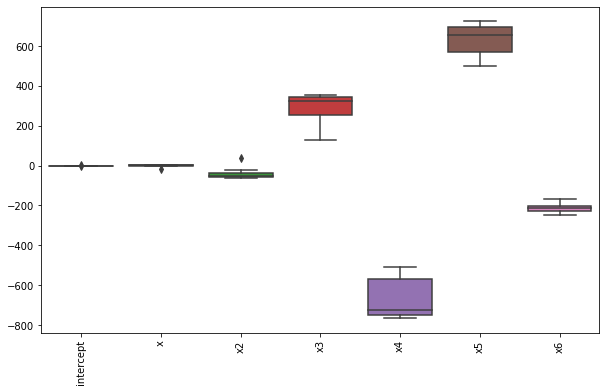

In [43]:
r = pd.DataFrame()

kf = KFold(n_splits=10)                        
for train, test in kf.split(range(25)):
    
    ridge = Ridge(
        alpha=0.00000005,    #
        fit_intercept=True,  #
        normalize=False,     #
        copy_X=True,         #
        max_iter=None,       #
        tol=0.001,           #
        solver='auto',       # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'}
        random_state=None)   #
    
    ridge.fit(X.loc[train,:], y[train])
    
    s = pd.DataFrame({
        'intercept': ridge.intercept_,
        'x':  [ridge.coef_[0]],
        'x2': [ridge.coef_[1]],
        'x3': [ridge.coef_[2]],
        'x4': [ridge.coef_[3]],
        'x5': [ridge.coef_[4]],
        'x6': [ridge.coef_[5]]
    })
    
    r = pd.concat([r, s])
    
plt.figure(figsize=(10, 6))
sns.boxplot(data=r)
plt.xticks(rotation=90);    

### Mejor modelo obtenido usando Ridge Regression

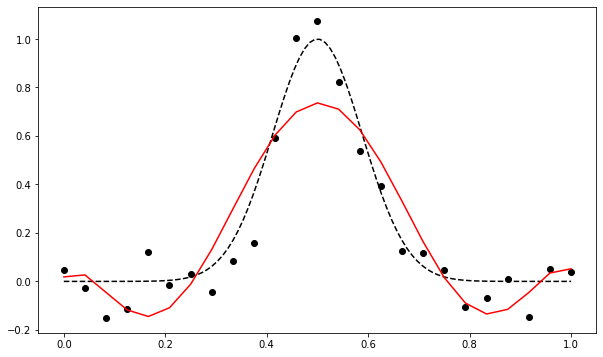

In [48]:
plt.figure(figsize=(10,6))

ridge = Ridge(
    alpha=0.00000005,    #
    fit_intercept=True,  #
    normalize=False,     #
    copy_X=True,         #
    max_iter=None,       #
    tol=0.001,           #
    solver='auto',       # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'}
    random_state=None)   #

ridge.fit(X, y)
    
y_predict = ridge.predict(X)


plt.plot(x_data, d_data, 'o', color='black');
plt.plot(x_real, d_real, '--', color='black');
plt.plot(df.x, y_predict, color='red');

## LASSO

En este modelo, el término de penalización es el valor absoluto de los coeficientes del modelo de regresión. Mientras que en la regresión ridge, los coeficientes $w_i$ tienden a ser pequeños, LASSO tiende a llevarlos a cero:

$$ \sum_{i=1}^N (y_i -  w_0 - \sum_{p=0}^P w_p x_{i,p})^2 + \alpha * \sum_{p=0}^P ||w_p|| $$


### Efecto de alpha sobre los coeficientes del modelo

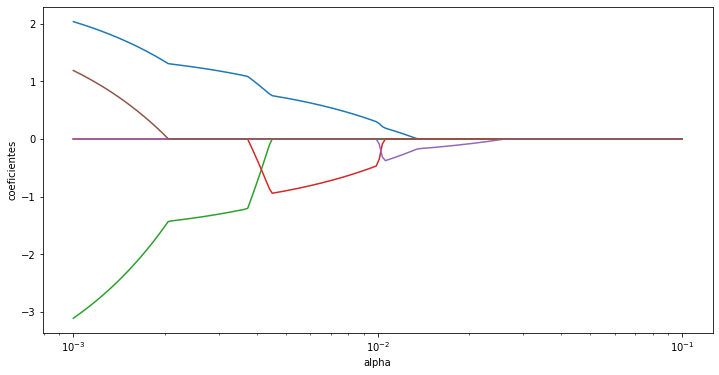

In [67]:
from sklearn.linear_model import Lasso

## https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

lasso = Lasso(
    alpha=1.0,            #
    fit_intercept=True,   #
    normalize=False,      #
    precompute=True,    #
    copy_X=True,          # 
    max_iter=100000,      #
    tol=0.000001,         #
    warm_start=True,      #
    positive=False,       #
    random_state=12345,   #
    selection='random')   #
    
coefs = []

alphas = np.logspace(-3, -1, 200)

y = df.y
X = df[['x', 'x2', 'x3', 'x4', 'x5', 'x6']]

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

plt.figure(figsize=(12, 6))
plt.plot(alphas, coefs)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coeficientes')
plt.axis('tight');

In [75]:
from sklearn.linear_model import LassoCV

lassoCV = LassoCV(
    alphas = 10 ** np.linspace(-1.5, 0, 200),
    cv = 20
)

lassoCV.fit(X, y)

LassoCV(alphas=array([0.03162278, 0.03217642, 0.03273975, 0.03331295, 0.03389618,
       0.03448962, 0.03509346, 0.03570786, 0.03633302, 0.03696913,
       0.03761637, 0.03827494, 0.03894505, 0.03962689, 0.04032066,
       0.04102658, 0.04174486, 0.04247572, 0.04321937, 0.04397604,
       0.04474595, 0.04552935, 0.04632646, 0.04713753, 0.0479628 ,
       0.04880252, 0.04965693, 0.05052631, 0.05141091, 0.05231099...
       0.78428221, 0.79801315, 0.8119845 , 0.82620045, 0.84066529,
       0.85538337, 0.87035914, 0.88559709, 0.90110183, 0.91687801,
       0.9329304 , 0.94926383, 0.96588322, 0.98279358, 1.        ]),
        copy_X=True, cv=20, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

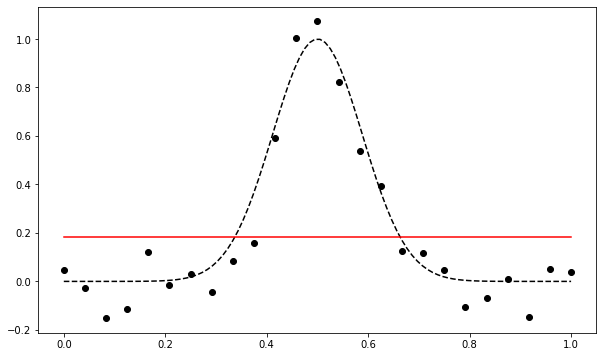

In [84]:
plt.figure(figsize=(10,6))

y_predict = lassoCV.predict(X)

plt.plot(x_data, d_data, 'o', color='black');
plt.plot(x_real, d_real, '--', color='black');
plt.plot(df.x, y_predict, color='red');

## Elastic Net

Este modelo combina las penalizaciones de ridge y LASSO en un solo modelo:

$$ \sum_{i=1}^N (y_i - w_0 - w_1 x_i)^2 + \alpha \rho * (|w_0| + |w_1|) + \frac{\alpha (1 - \rho)}{2}(w_0^2 + w_1^2)$$
